# Системы машинного обучения в Production

- - -
## Содержание<a class="anchor" id="toc"></a>
* [Содержание](#toc)
* [Введение в проект](#intro)
    * [Постановка задачи](#intro_task)
    * [Описание сырых данных](#intro_description)
    * [Подключение библиотек и скриптов](#intro_imports)
    * [Путь к директориям и файлам](#intro_paths)
    * [Инициализация пайплайна](#intro_pipeline)
* [Составление тренировочного датасета](#compose)
    * [Подготовка данных](#compose_prepare)
    * [Объединение в единый датасет](#compose_join)
* [Препроцессинг](#preprocess)
    * [Обаботка категориальных признаков](#preprocess_categories)
    * [Обработка выбросов](#preprocess_outliers)
    * [Обработка пропусков](#preprocess_gaps)
* [Анализ данных](#analysis)
    * [Анализ целевой переменной](#analysis_target)
    * [Анализ признакового пространства](#analysis_corr)
* [Обучение на данных](#ml)
    * [Отбор признаков](#ml_feature_selection)
    * [Нормализация](#ml_normalize)
    * [Разбиение на train и test](#ml_split)
    * [Балансировка классов](#ml_balancing)
    * [Подбор моделей](#ml_model_selection)
    * [Подбор гиперпараметров](#ml_hyper)
    * [Проверка качества, борьба с переобучением](#ml_overfittig)
    * [Сохранение модели](#ml_persist)
* [Экспорт результатов](#export)
    * [Загрузка private выборки](#export_load)
    * [Трансформация датасета](#export_transformation)
    * [Предсказание результатов](#export_prediction)
    * [Сохранение результатов](#export_predicted)
* [Интерпретация результатов](#interpretation)

- - -
## Введение в проект<a class="anchor" id="intro"></a>

### Постановка задачи<a class="anchor" id="task"></a>

**Задача**
1. Необходимо, используя сырые данные игровых логов, собрать датасет, предобработать его и обучить модель, предсказывающую уход игрока из проекта.
2. Аналогичным с обучающей выборкой образом нужно сформировать признаковое описание игроков для тестовой выборки и сделать прогноз для игроков из тестового датасета.
3. Проект оформить в виде *.py модулей и скриптов проекта в PyCharm, где функционал и все этапы решения задачи разнесены по модулям.

**Наименование файлов с данными**
* train/\*.csv — файлы для обучающего датасета
* test/\*.csv — файлы для тестового датасета

**Целевая переменная**
**is_churned** - уход игрока из проекта

**Метрика качества**
F1-score

**Требования к решению**
* F1 > 0.4
* Метрика оценивается по качеству прогноза для главного класса (1 - уход из игры)
* Jupyter Notebook с кодом решения
* CSV-файл с прогнозами (два столбца: user_id | is_churned)
* Ход решения должен быть последовательным, сопровождаться комментариями

**Сроки сдачи**
Cдать проект нужно в течение 5 дней после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Описание сырых данных<a class="anchor" id="description"></a>

**profiles** — профили
* user_id — идентификатор игрока (во всех остальных файлах имеет тот же смысл)
* age — возраст (получен из даты рождения, что указана в БД)
* gender — пол (M – Male, F – Female)
* days_between_reg_fl — дней между регистрацией и первым входом
* days_between_fl_df — дней между первым входом и первым платежом
* has_return_date — есть дата возврата (игрок когда-то уходил и возвращался)
* has_phone_number — есть привязка номера телефона к аккаунту

**payments** — платежи
* log_dt — дата события (во всех остальных файлах имеет тот же смысл)
* pay_amt — размер внесенных средств (сумма платежей за данную дату)
* trans_amt — кол-во транзакций за данную даты

**reports** — жалобы игрока на других пользователей
* reports_amt — кол-во жалоб (на читы/оскорбления)

**abusers** — сессии с нарушителями
* sess_with_abusers_amt — кол-во сессий с теми, на кого жаловались другие игроки

**logins** — входы
* disconnect_amt — кол-во завершений игры из-за технической проблемы
* session_amt — кол-во сессий (от входа в клиент игры до выхода)

**pings** — пинг до серверов (чем меньше, тем лучше интернет соединение и игра меньше "глючит")
* avg_min_ping — средний за данную дату пинг до ближайшего сервера

**sessions** — информация о сессиях (матчах)
* kd — Kills/Deaths — отношение убийств к смертям, то есть насколько успешно играл пользователь
* win_rate — Wins/Matches — отношение кол-во матчей, закончившихся победой, к общему числу матчей, тоже мера успешности
* leavings_rate — Leavings/Matches — отношение кол-во матчей, покинутых игроком, к общему числу матчей
* session_player — суммарное время в матчах за данную дату (в секундах)

**shop** — активность в магазине
* silver_spent — траты серебра
* gold_spent — траты золота

### Подключение библиотек и скриптов<a class="anchor" id="intro_imports"></a>

Напишем magic функцию, которая будет одновременно выполнять код ячейки и экспортировать его в файл, так как встроенная функция `%%writefile` такой функциональности не поддерживает

In [1]:
from IPython.core.magic import register_cell_magic


@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell + '\n\n')
    get_ipython().run_cell(cell)

Импортируем библиотеки, которые понадобятся одновременно и в скрипте и в ноутбуке

In [2]:
%%write_and_run main.py
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals.joblib import dump, load
import catboost as catb

/Users/a.iatsuk/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Импортируем библиотеки для ноутбука

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'png'
%matplotlib inline
pd.options.display.max_columns = 100
pd.set_option('display.max_colwidth', -1)

### Путь к директориям и файлам<a class="anchor" id="intro_paths"></a>

Пути, которые будем использовать в ноутбуке

In [4]:
ABUSERS_PATH = 'train/abusers.csv'
LOGINS_PATH = 'train/logins.csv'
NUCLEAR_PATH = 'train/nuclear.csv'
PAYMENTS_PATH = 'train/payments.csv'
PINGS_PATH = 'train/pings.csv'
PROFILES_PATH = 'train/profiles.csv'
REPORTS_PATH = 'train/reports.csv'
SAMPLE_PATH = 'train/sample.csv'
SESSIONS_PATH = 'train/sessions.csv'
SHOP_PATH = 'train/shop.csv'

Пути, которые будем использовать в скрипте

In [5]:
%%writefile -a main.py
############################## PATHS ##############################
ABUSERS_PATH = 'test/abusers.csv'
LOGINS_PATH = 'test/logins.csv'
NUCLEAR_PATH = 'test/nuclear.csv'
PAYMENTS_PATH = 'test/payments.csv'
PINGS_PATH = 'test/pings.csv'
PROFILES_PATH = 'test/profiles.csv'
REPORTS_PATH = 'test/reports.csv'
SAMPLE_PATH = 'test/sample.csv'
SESSIONS_PATH = 'test/sessions.csv'
SHOP_PATH = 'test/shop.csv'




Appending to main.py


### Инициализация пайплайна<a class="anchor" id="intro_pipeline"></a>

Все функции с преобразованиями будем помечать аннотацией `@pipeline_step`, чтобы потом одним вызовом их всех применить на тренировочном датасете

In [6]:
%%writefile -a main.py
############################## PIPELINE ##############################

Appending to main.py


In [7]:
%%write_and_run -a main.py
pipeline = []

In [8]:
%%write_and_run -a main.py
def pipeline_step(func):
    def wrap(a):
        pipeline.append(func)
        return func(a)
    return wrap

In [9]:
%%write_and_run -a main.py
def run_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    result = df.copy()
    for step in pipeline:
        result = step(result)
    return result

- - -
## Составление тренировочного датасета<a class="anchor" id="compose"></a>

### Подготовка данных<a class="anchor" id="compose_prepare"></a>

In [61]:
%%write_and_run -a main.py
############################## LOAD RAW ##############################
df_abusers = pd.read_csv(ABUSERS_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_logins = pd.read_csv(LOGINS_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_nuclear = pd.read_csv(NUCLEAR_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_payments = pd.read_csv(PAYMENTS_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_pings = pd.read_csv(PINGS_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_profiles = pd.read_csv(PROFILES_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_reports = pd.read_csv(REPORTS_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_sample = pd.read_csv(SAMPLE_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_sessions = pd.read_csv(SESSIONS_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')
df_shop = pd.read_csv(SHOP_PATH, sep=';', na_values=['\\N', 'None'], encoding='utf-8')

In [114]:
%%write_and_run -a main.py
str2xname = {
    '2019-08-05': 'x8',
    '2019-08-12': 'x7',
    '2019-08-19': 'x6',
    '2019-08-26': 'x5',
    '2019-09-02': 'x4',
    '2019-09-09': 'x3',
    '2019-09-16': 'x2',
    '2019-09-23': 'x1',
    '2019-09-30': 'x0',
}


def rename_multi_index_cols(df):
    date2str = lambda ts: str(ts).split()[0]
    date2xname = lambda ts: str2xname[date2str(ts)]
    col2str = lambda tup: f'{tup[0]}_{date2xname(tup[1])}'.rstrip('_')
    df.columns = [col2str(tup) for tup in df.columns.values]
    return df


def rename_date_cols(df, prefix):
    date2str = lambda ts: str(ts).split('T')[0]
    date2xname = lambda ts: str2xname[date2str(ts)]
    df.columns = [f'{prefix}_{date2xname(col)}' for col in df.columns.values]
    return df

In [192]:
%%write_and_run -a main.py
df_to_merge = []

**abusers**

In [193]:
%%write_and_run -a main.py
df_abusers_cast = df_abusers.copy()
df_abusers_cast['log_dt'] =  pd.to_datetime(df_abusers_cast['log_dt'], format='%Y-%m-%d')

df_abusers_agg = df_abusers_cast \
    .groupby(['user_id', pd.Grouper(key='log_dt', freq='W-MON')]) \
    .sum() \
    .reset_index() \
    .pivot(index='user_id', columns='log_dt', values='sess_with_abusers_amt') \
    .fillna(0)
df_abusers_agg = rename_date_cols(df_abusers_agg, 'sess_with_abusers_amt')

df_to_merge.append(df_abusers_agg)

In [191]:
display(df_abusers_agg.head(3))
display(df_abusers_agg.info(null_counts=True))

,sess_with_abusers_amt_x8,sess_with_abusers_amt_x7,sess_with_abusers_amt_x6,sess_with_abusers_amt_x5,sess_with_abusers_amt_x4,sess_with_abusers_amt_x3,sess_with_abusers_amt_x2,sess_with_abusers_amt_x1,sess_with_abusers_amt_x0
user_id,,,,,,,,,
00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa,2.0,38.0,21.0,9.0,15.0,27.0,19.0,25.0,16.0
00005d03d47130a93ec8694fc06e003ac41bf25a8acc0e790e703958c8117ce6,20.0,22.0,17.0,15.0,22.0,5.0,6.0,14.0,11.0
00005f0f4b503dcbe368d8610b2a5ba5202354a86edee41d961d362dfc4286a2,0.0,0.0,23.0,21.0,0.0,0.0,29.0,0.0,15.0


<class 'pandas.core.frame.DataFrame'>
Index: 380937 entries, 00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa to ffffcdc0e8ec6761dacf730170fc93b4211cf10c828fa20cfd02b84f26cd4962
Data columns (total 9 columns):
sess_with_abusers_amt_x8    380937 non-null float64
sess_with_abusers_amt_x7    380937 non-null float64
sess_with_abusers_amt_x6    380937 non-null float64
sess_with_abusers_amt_x5    380937 non-null float64
sess_with_abusers_amt_x4    380937 non-null float64
sess_with_abusers_amt_x3    380937 non-null float64
sess_with_abusers_amt_x2    380937 non-null float64
sess_with_abusers_amt_x1    380937 non-null float64
sess_with_abusers_amt_x0    380937 non-null float64
dtypes: float64(9)
memory usage: 29.1+ MB


None

**logins**

In [194]:
%%write_and_run -a main.py
df_logins_cast = df_logins.copy()
df_logins_cast['log_dt'] =  pd.to_datetime(df_logins_cast['log_dt'], format='%Y-%m-%d')

df_logins_agg = df_logins_cast \
    .groupby(['user_id', pd.Grouper(key='log_dt', freq='W-MON')]) \
    .sum() \
    .reset_index() \
    .pivot(index='user_id', columns='log_dt', values=['disconnect_amt', 'session_amt']) \
    .fillna(0)
df_logins_agg = rename_multi_index_cols(df_logins_agg)

df_to_merge.append(df_logins_agg)

In [189]:
display(df_logins_agg.head(3))
display(df_logins_agg.info(null_counts=True))

,disconnect_amt_x8,disconnect_amt_x7,disconnect_amt_x6,disconnect_amt_x5,disconnect_amt_x4,disconnect_amt_x3,disconnect_amt_x2,disconnect_amt_x1,disconnect_amt_x0,session_amt_x8,session_amt_x7,session_amt_x6,session_amt_x5,session_amt_x4,session_amt_x3,session_amt_x2,session_amt_x1,session_amt_x0
user_id,,,,,,,,,,,,,,,,,,
00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa,0.0,3.0,2.0,1.0,4.0,3.0,3.0,4.0,3.0,3.0,6.0,7.0,4.0,2.0,3.0,4.0,7.0,4.0
00005d03d47130a93ec8694fc06e003ac41bf25a8acc0e790e703958c8117ce6,3.0,3.0,0.0,1.0,5.0,1.0,1.0,4.0,2.0,10.0,11.0,6.0,9.0,8.0,5.0,5.0,17.0,15.0
00005f0f4b503dcbe368d8610b2a5ba5202354a86edee41d961d362dfc4286a2,0.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,8.0,0.0,1.0,19.0,1.0,5.0


<class 'pandas.core.frame.DataFrame'>
Index: 403856 entries, 00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa to ffffcdc0e8ec6761dacf730170fc93b4211cf10c828fa20cfd02b84f26cd4962
Data columns (total 18 columns):
disconnect_amt_x8    403856 non-null float64
disconnect_amt_x7    403856 non-null float64
disconnect_amt_x6    403856 non-null float64
disconnect_amt_x5    403856 non-null float64
disconnect_amt_x4    403856 non-null float64
disconnect_amt_x3    403856 non-null float64
disconnect_amt_x2    403856 non-null float64
disconnect_amt_x1    403856 non-null float64
disconnect_amt_x0    403856 non-null float64
session_amt_x8       403856 non-null float64
session_amt_x7       403856 non-null float64
session_amt_x6       403856 non-null float64
session_amt_x5       403856 non-null float64
session_amt_x4       403856 non-null float64
session_amt_x3       403856 non-null float64
session_amt_x2       403856 non-null float64
session_amt_x1       403856 non-null float64
session_

None

**nuclear**

In [195]:
%%write_and_run -a main.py
def cast_nuclear(df):
    def process(s):
        if s == 'Core':
            return 0
        elif s == 'Mantle':
            return 1
        elif s == 'Returns':
            return 2
        else:
            return 3

    result = df.copy()
    result['core_type_nm'] = df['core_type_nm'].apply(process)    
    return result

df_nuclear_cast = cast_nuclear(df_nuclear)
df_nuclear_cast = df_nuclear_cast.set_index('user_id')

df_to_merge.append(df_nuclear_cast)

In [187]:
display(df_nuclear_cast.head(3))
display(df_nuclear_cast.info(null_counts=True))

,core_type_nm
user_id,
a01bf165f12cd7cc5c38a5bbed8c28060fffee64f7b1e66a6662801d3b3d9f3f,1
eac0a6f4b720c4b34ae41ea4f976875a5df697aedd2d224a23c6e87338ca9f62,2
17fc5d60c747f3fdd98f5e7a3757ce84eb87bec0c1de6129822715fe1890595f,2


<class 'pandas.core.frame.DataFrame'>
Index: 368088 entries, a01bf165f12cd7cc5c38a5bbed8c28060fffee64f7b1e66a6662801d3b3d9f3f to ff45c4ac6d5639c509babb360b1f81dba5b04e706eba782a481615ebb4963032
Data columns (total 1 columns):
core_type_nm    368088 non-null int64
dtypes: int64(1)
memory usage: 5.6+ MB


None

**payments**

In [196]:
%%write_and_run -a main.py
df_payments_cast = df_payments.copy()
df_payments_cast['log_dt'] =  pd.to_datetime(df_payments_cast['log_dt'], format='%Y-%m-%d')

df_payments_agg = df_payments_cast \
    .groupby(['user_id', pd.Grouper(key='log_dt', freq='W-MON')]) \
    .sum() \
    .reset_index() \
    .pivot(index='user_id', columns='log_dt', values=['pay_amt', 'trans_amt']) \
    .fillna(0)
df_payments_agg = rename_multi_index_cols(df_payments_agg)

df_to_merge.append(df_payments_agg)

In [185]:
display(df_payments_agg.head(3))
display(df_payments_agg.info(null_counts=True))

,pay_amt_x8,pay_amt_x7,pay_amt_x6,pay_amt_x5,pay_amt_x4,pay_amt_x3,pay_amt_x2,pay_amt_x1,pay_amt_x0,trans_amt_x8,trans_amt_x7,trans_amt_x6,trans_amt_x5,trans_amt_x4,trans_amt_x3,trans_amt_x2,trans_amt_x1,trans_amt_x0
user_id,,,,,,,,,,,,,,,,,,
00005d03d47130a93ec8694fc06e003ac41bf25a8acc0e790e703958c8117ce6,0.0,2000.0,0.0,2000.0,1800.0,0.0,0.0,0.0,2000.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0
00005f0f4b503dcbe368d8610b2a5ba5202354a86edee41d961d362dfc4286a2,0.0,0.0,1178.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0000617a7b243217fac191d0ba4feb683f21a9297690e5daba60026c00b1cb39,900.0,0.0,0.0,0.0,692.0,3158.0,0.0,4056.0,644.0,1.0,0.0,0.0,0.0,4.0,5.0,0.0,4.0,2.0


<class 'pandas.core.frame.DataFrame'>
Index: 211571 entries, 00005d03d47130a93ec8694fc06e003ac41bf25a8acc0e790e703958c8117ce6 to ffff62e18a714760405b2a875f4439014a52eb088ebf944ed37a8e4b7579ca3b
Data columns (total 18 columns):
pay_amt_x8      211571 non-null float64
pay_amt_x7      211571 non-null float64
pay_amt_x6      211571 non-null float64
pay_amt_x5      211571 non-null float64
pay_amt_x4      211571 non-null float64
pay_amt_x3      211571 non-null float64
pay_amt_x2      211571 non-null float64
pay_amt_x1      211571 non-null float64
pay_amt_x0      211571 non-null float64
trans_amt_x8    211571 non-null float64
trans_amt_x7    211571 non-null float64
trans_amt_x6    211571 non-null float64
trans_amt_x5    211571 non-null float64
trans_amt_x4    211571 non-null float64
trans_amt_x3    211571 non-null float64
trans_amt_x2    211571 non-null float64
trans_amt_x1    211571 non-null float64
trans_amt_x0    211571 non-null float64
dtypes: float64(18)
memory usage: 30.7+ MB


None

**ping**

In [197]:
%%write_and_run -a main.py
def avg_min_ping_cast(value):
    try:
        result = float(value)
    except:
        result = 999.0
    return result


df_pings_cast = df_pings.copy()
df_pings_cast['log_dt'] =  pd.to_datetime(df_pings_cast['log_dt'], format='%Y-%m-%d')
df_pings_cast['avg_min_ping'] =  df_pings_cast['avg_min_ping'].apply(avg_min_ping_cast)

df_pings_agg = df_pings_cast \
    .groupby(['user_id', pd.Grouper(key='log_dt', freq='W-MON')]) \
    .median() \
    .reset_index() \
    .pivot(index='user_id', columns='log_dt', values='avg_min_ping') \
    .fillna(999)
df_pings_agg = rename_date_cols(df_pings_agg, 'avg_min_ping')

df_to_merge.append(df_pings_agg)

In [183]:
display(df_pings_agg.head(3))
display(df_pings_agg.info(null_counts=True))

,avg_min_ping_x8,avg_min_ping_x7,avg_min_ping_x6,avg_min_ping_x5,avg_min_ping_x4,avg_min_ping_x3,avg_min_ping_x2,avg_min_ping_x1,avg_min_ping_x0
user_id,,,,,,,,,
00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa,33.5,32.0,32.555557,36.0,32.666666,32.0,33.00,34.833333,39.5
00005d03d47130a93ec8694fc06e003ac41bf25a8acc0e790e703958c8117ce6,18.0,18.0,18.166667,18.0,18.100000,18.5,18.00,18.000000,18.5
00005f0f4b503dcbe368d8610b2a5ba5202354a86edee41d961d362dfc4286a2,999.0,16.0,13.000000,12.5,999.000000,13.0,9.75,15.000000,11.0


<class 'pandas.core.frame.DataFrame'>
Index: 405892 entries, 00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa to ffffcdc0e8ec6761dacf730170fc93b4211cf10c828fa20cfd02b84f26cd4962
Data columns (total 9 columns):
avg_min_ping_x8    405892 non-null float64
avg_min_ping_x7    405892 non-null float64
avg_min_ping_x6    405892 non-null float64
avg_min_ping_x5    405892 non-null float64
avg_min_ping_x4    405892 non-null float64
avg_min_ping_x3    405892 non-null float64
avg_min_ping_x2    405892 non-null float64
avg_min_ping_x1    405892 non-null float64
avg_min_ping_x0    405892 non-null float64
dtypes: float64(9)
memory usage: 31.0+ MB


None

**profiles**

In [198]:
%%write_and_run -a main.py
def profiles_age_cast(value):
    median = 24.0
    try:
        result = float(value)
    except:
        result = median
    return result


def profiles_gender_cast(value):
    if value == 'M':
        return 1
    elif value == 'F':
        return 0
    else:
        return 0.5
    return result


df_profiles_cast = df_profiles.copy()
df_profiles_cast['age'] = df_profiles_cast['age'].apply(profiles_age_cast)
df_profiles_cast['gender'] = df_profiles_cast['gender'].apply(profiles_gender_cast)
df_profiles_cast = df_profiles_cast.set_index('user_id')

df_to_merge.append(df_profiles_cast)

In [181]:
display(df_profiles_cast.head(3))
display(df_profiles_cast.info())

,age,gender,days_between_reg_fl,days_between_fl_df,has_return_date,has_phone_number
user_id,,,,,,
e54f91bf5895d0c433fd1cd3092ab4ad94ea953845f4a847e580675515d48da0,NaN,0.5,0,30,1,1
f1ab2f683a3b37c9f9f6cb107629178cdcc34eaf684b6718eb030b5650b4be72,22.0,1.0,0,34,1,0
0dc419c3401bb042fea254ae11c4bfc5e1418f2ab63c8b05c85762ac2d14b7be,22.0,1.0,0,13,1,1


<class 'pandas.core.frame.DataFrame'>
Index: 469475 entries, e54f91bf5895d0c433fd1cd3092ab4ad94ea953845f4a847e580675515d48da0 to fbbae6d941b31b19705068aa2eee2a92cf67f9829cae1c5eb6c8c1899d0af031
Data columns (total 6 columns):
age                    390924 non-null float64
gender                 469475 non-null float64
days_between_reg_fl    469475 non-null int64
days_between_fl_df     469475 non-null int64
has_return_date        469475 non-null int64
has_phone_number       469475 non-null int64
dtypes: float64(2), int64(4)
memory usage: 25.1+ MB


None

**reports**

In [199]:
%%write_and_run -a main.py
df_reports_cast = df_reports.copy()
df_reports_cast['log_dt'] =  pd.to_datetime(df_reports_cast['log_dt'], format='%Y-%m-%d')

df_reports_agg = df_reports_cast \
    .groupby(['user_id', pd.Grouper(key='log_dt', freq='W-MON')]) \
    .sum() \
    .reset_index() \
    .pivot(index='user_id', columns='log_dt', values='reports_amt') \
    .fillna(0)
df_reports_agg = rename_date_cols(df_reports_agg, 'reports_amt')

df_to_merge.append(df_reports_agg)

In [179]:
display(df_reports_agg.head(3))
display(df_reports_agg.info())

,reports_amt_x8,reports_amt_x7,reports_amt_x6,reports_amt_x5,reports_amt_x4,reports_amt_x3,reports_amt_x2,reports_amt_x1,reports_amt_x0
user_id,,,,,,,,,
00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa,0.0,2.0,1.0,2.0,1.0,3.0,0.0,1.0,0.0
00005d03d47130a93ec8694fc06e003ac41bf25a8acc0e790e703958c8117ce6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00005f0f4b503dcbe368d8610b2a5ba5202354a86edee41d961d362dfc4286a2,0.0,0.0,2.0,2.0,0.0,0.0,5.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 290200 entries, 00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa to ffffcdc0e8ec6761dacf730170fc93b4211cf10c828fa20cfd02b84f26cd4962
Data columns (total 9 columns):
reports_amt_x8    290200 non-null float64
reports_amt_x7    290200 non-null float64
reports_amt_x6    290200 non-null float64
reports_amt_x5    290200 non-null float64
reports_amt_x4    290200 non-null float64
reports_amt_x3    290200 non-null float64
reports_amt_x2    290200 non-null float64
reports_amt_x1    290200 non-null float64
reports_amt_x0    290200 non-null float64
dtypes: float64(9)
memory usage: 22.1+ MB


None

**sample**

In [200]:
%%write_and_run -a main.py
df_sample_cast = df_sample.copy()
df_sample_cast['login_last_dt'] = (pd.to_datetime(df_sample_cast['login_last_dt'], format='%Y-%m-%d') - pd.to_datetime('2019-09-30', format='%Y-%m-%d')) / np.timedelta64(-1, 'D')
df_sample_cast = df_sample_cast.set_index('user_id')

df_to_merge.append(df_sample_cast)

In [177]:
display(df_sample_cast.head(3))
display(df_sample_cast.info(null_counts=True))

,is_churned,login_last_dt,level,donate_total
user_id,,,,
1e7edd8347e3aaeedf8c494b11240851e3fa0ad231b8f89734a54213cd69a1e6,0,27.0,43,88730.0
f43cac5f14e06ca039b173e14c323ac0c1fd8492f0cf082804f651cfca1c6f52,0,12.0,50,44149.0
cc7450e0b182947998534ef137b05e07109c100aced0b6c0a5d1f253c515101f,0,8.0,37,44931.0


<class 'pandas.core.frame.DataFrame'>
Index: 469475 entries, 1e7edd8347e3aaeedf8c494b11240851e3fa0ad231b8f89734a54213cd69a1e6 to a967ae57ac695531c02cc57fe3790d820a8f9a93d25486e9cc9a8af3b764b639
Data columns (total 4 columns):
is_churned       469475 non-null int64
login_last_dt    469475 non-null float64
level            469475 non-null int64
donate_total     469475 non-null float64
dtypes: float64(2), int64(2)
memory usage: 17.9+ MB


None

**sessions**

In [201]:
%%write_and_run -a main.py
df_sessions_cast = df_sessions.copy()
df_sessions_cast['log_dt'] = pd.to_datetime(df_sessions_cast['log_dt'], format='%Y-%m-%d')

df_sessions_agg = df_sessions_cast \
    .groupby(['user_id', pd.Grouper(key='log_dt', freq='W-MON')]) \
    .median() \
    .reset_index() \
    .pivot(index='user_id', columns='log_dt', values=['kd', 'win_rate', 'leavings_rate', 'session_player']) \
    .fillna(0)
df_sessions_agg = rename_multi_index_cols(df_sessions_agg)

df_to_merge.append(df_sessions_agg)

In [171]:
display(df_sessions_agg.head(3))
display(df_sessions_agg.info(null_counts=True))

,kd_x8,kd_x7,kd_x6,kd_x5,kd_x4,kd_x3,kd_x2,kd_x1,kd_x0,win_rate_x8,win_rate_x7,win_rate_x6,win_rate_x5,win_rate_x4,win_rate_x3,win_rate_x2,win_rate_x1,win_rate_x0,leavings_rate_x8,leavings_rate_x7,leavings_rate_x6,leavings_rate_x5,leavings_rate_x4,leavings_rate_x3,leavings_rate_x2,leavings_rate_x1,leavings_rate_x0,session_player_x8,session_player_x7,session_player_x6,session_player_x5,session_player_x4,session_player_x3,session_player_x2,session_player_x1,session_player_x0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa,12.740937,1.037805,0.869048,1.687500,1.613385,0.833333,3.959430,0.937554,6.000000,1.75,0.906250,0.750000,1.000000,2.166667,0.454545,0.800000,1.555556,1.000000,0.071429,0.020833,0.0,0.0,0.062500,0.0,0.03125,0.0,0.0,3046.0,10801.5,4061.0,4643.0,5204.0,2692.0,6817.5,5092.0,6391.0
00005d03d47130a93ec8694fc06e003ac41bf25a8acc0e790e703958c8117ce6,0.986799,1.031908,1.250000,0.978105,1.006594,1.147059,1.111111,1.084615,1.000000,1.00,0.857143,0.750000,1.500000,0.750000,1.000000,2.000000,1.000000,0.125000,0.000000,0.000000,0.0,0.0,0.066667,0.0,0.00000,0.0,0.0,9670.0,4837.0,3361.0,2805.0,4798.0,803.0,3304.0,3472.0,2202.5
00005f0f4b503dcbe368d8610b2a5ba5202354a86edee41d961d362dfc4286a2,0.000000,0.000000,0.627328,0.545076,0.000000,0.000000,0.715134,0.000000,0.424242,0.00,0.000000,0.479167,0.733333,0.000000,0.000000,0.291667,0.000000,0.111111,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,4843.5,3250.5,0.0,0.0,2841.5,0.0,2491.0


<class 'pandas.core.frame.DataFrame'>
Index: 395493 entries, 00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa to ffffcdc0e8ec6761dacf730170fc93b4211cf10c828fa20cfd02b84f26cd4962
Data columns (total 36 columns):
kd_x8                395493 non-null float64
kd_x7                395493 non-null float64
kd_x6                395493 non-null float64
kd_x5                395493 non-null float64
kd_x4                395493 non-null float64
kd_x3                395493 non-null float64
kd_x2                395493 non-null float64
kd_x1                395493 non-null float64
kd_x0                395493 non-null float64
win_rate_x8          395493 non-null float64
win_rate_x7          395493 non-null float64
win_rate_x6          395493 non-null float64
win_rate_x5          395493 non-null float64
win_rate_x4          395493 non-null float64
win_rate_x3          395493 non-null float64
win_rate_x2          395493 non-null float64
win_rate_x1          395493 non-null float64
win_rate

None

**shop**

In [202]:
%%write_and_run -a main.py
df_shop_cast = df_shop.copy()
df_shop_cast['log_dt'] = pd.to_datetime(df_shop_cast['log_dt'], format='%Y-%m-%d')

df_shop_agg = df_shop_cast \
    .groupby(['user_id', pd.Grouper(key='log_dt', freq='W-MON')]) \
    .sum() \
    .reset_index() \
    .pivot(index='user_id', columns='log_dt', values=['silver_spent', 'gold_spent']) \
    .fillna(0)
df_shop_agg = rename_multi_index_cols(df_shop_agg)

df_to_merge.append(df_shop_agg)

In [169]:
display(df_shop_agg.head(3))
display(df_shop_agg.info(null_counts=True))

,silver_spent_x8,silver_spent_x7,silver_spent_x6,silver_spent_x5,silver_spent_x4,silver_spent_x3,silver_spent_x2,silver_spent_x1,silver_spent_x0,gold_spent_x8,gold_spent_x7,gold_spent_x6,gold_spent_x5,gold_spent_x4,gold_spent_x3,gold_spent_x2,gold_spent_x1,gold_spent_x0
user_id,,,,,,,,,,,,,,,,,,
00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa,0.0,19000.0,18900.0,0.0,98000.0,0.0,0.0,41500.0,25200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00005d03d47130a93ec8694fc06e003ac41bf25a8acc0e790e703958c8117ce6,0.0,0.0,0.0,0.0,0.0,0.0,141200.0,85850.0,76850.0,0.0,4964.0,0.0,4556.0,4710.0,0.0,0.0,0.0,0.0
00005f0f4b503dcbe368d8610b2a5ba5202354a86edee41d961d362dfc4286a2,0.0,0.0,0.0,0.0,0.0,0.0,80000.0,0.0,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,0.0,24.0


<class 'pandas.core.frame.DataFrame'>
Index: 407755 entries, 00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa to ffffcdc0e8ec6761dacf730170fc93b4211cf10c828fa20cfd02b84f26cd4962
Data columns (total 18 columns):
silver_spent_x8    407755 non-null float64
silver_spent_x7    407755 non-null float64
silver_spent_x6    407755 non-null float64
silver_spent_x5    407755 non-null float64
silver_spent_x4    407755 non-null float64
silver_spent_x3    407755 non-null float64
silver_spent_x2    407755 non-null float64
silver_spent_x1    407755 non-null float64
silver_spent_x0    407755 non-null float64
gold_spent_x8      407755 non-null float64
gold_spent_x7      407755 non-null float64
gold_spent_x6      407755 non-null float64
gold_spent_x5      407755 non-null float64
gold_spent_x4      407755 non-null float64
gold_spent_x3      407755 non-null float64
gold_spent_x2      407755 non-null float64
gold_spent_x1      407755 non-null float64
gold_spent_x0      407755 non-null float64

None

### Объединение в единый датасет<a class="anchor" id="compose_join"></a>

In [215]:
%%write_and_run main.py
############################## UNIFIED DATASET ##############################
df_merged = None
for df in df_to_merge:
    if df_merged is None:
        df_merged = df
    else:
        df_merged = df_merged.join(df, how='outer')
df_merged.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 469679 entries, 00002b09f70d42fb0eb23342fcdfe2130285619b70d0e8aeea4e3d6d3eebe0aa to ffffcdc0e8ec6761dacf730170fc93b4211cf10c828fa20cfd02b84f26cd4962
Columns: 128 entries, sess_with_abusers_amt_x8 to gold_spent_x0
dtypes: float64(122), int64(6)
memory usage: 462.3+ MB


In [226]:
df_merged.shape

(469679, 128)

In [223]:
{col[:-1] if col[-3:-1] == '_x' else col for col in df_merged.columns}

{'age',
 'avg_min_ping_x',
 'core_type_nm',
 'days_between_fl_df',
 'days_between_reg_fl',
 'disconnect_amt_x',
 'donate_total',
 'gender',
 'gold_spent_x',
 'has_phone_number',
 'has_return_date',
 'is_churned',
 'kd_x',
 'leavings_rate_x',
 'level',
 'login_last_dt',
 'pay_amt_x',
 'reports_amt_x',
 'sess_with_abusers_amt_x',
 'session_amt_x',
 'session_player_x',
 'silver_spent_x',
 'trans_amt_x',
 'win_rate_x'}

**Обзор целевой переменной**

In [227]:
df_merged['is_churned'].value_counts()

0    455650
1    14029 
Name: is_churned, dtype: int64

**Обзор количественных признаков**

In [228]:
df_merged.describe()

,sess_with_abusers_amt_x8,sess_with_abusers_amt_x7,sess_with_abusers_amt_x6,sess_with_abusers_amt_x5,sess_with_abusers_amt_x4,sess_with_abusers_amt_x3,sess_with_abusers_amt_x2,sess_with_abusers_amt_x1,sess_with_abusers_amt_x0,disconnect_amt_x8,disconnect_amt_x7,disconnect_amt_x6,disconnect_amt_x5,disconnect_amt_x4,disconnect_amt_x3,disconnect_amt_x2,disconnect_amt_x1,disconnect_amt_x0,session_amt_x8,session_amt_x7,session_amt_x6,session_amt_x5,session_amt_x4,session_amt_x3,session_amt_x2,session_amt_x1,session_amt_x0,core_type_nm,pay_amt_x8,pay_amt_x7,pay_amt_x6,pay_amt_x5,pay_amt_x4,pay_amt_x3,pay_amt_x2,pay_amt_x1,pay_amt_x0,trans_amt_x8,trans_amt_x7,trans_amt_x6,trans_amt_x5,trans_amt_x4,trans_amt_x3,trans_amt_x2,trans_amt_x1,trans_amt_x0,avg_min_ping_x8,avg_min_ping_x7,avg_min_ping_x6,avg_min_ping_x5,...,kd_x4,kd_x3,kd_x2,kd_x1,kd_x0,win_rate_x8,win_rate_x7,win_rate_x6,win_rate_x5,win_rate_x4,win_rate_x3,win_rate_x2,win_rate_x1,win_rate_x0,leavings_rate_x8,leavings_rate_x7,leavings_rate_x6,leavings_rate_x5,leavings_rate_x4,leavings_rate_x3,leavings_rate_x2,leavings_rate_x1,leavings_rate_x0,session_player_x8,session_player_x7,session_player_x6,session_player_x5,session_player_x4,session_player_x3,session_player_x2,session_player_x1,session_player_x0,silver_spent_x8,silver_spent_x7,silver_spent_x6,silver_spent_x5,silver_spent_x4,silver_spent_x3,silver_spent_x2,silver_spent_x1,silver_spent_x0,gold_spent_x8,gold_spent_x7,gold_spent_x6,gold_spent_x5,gold_spent_x4,gold_spent_x3,gold_spent_x2,gold_spent_x1,gold_spent_x0
count,381131.000000,381131.000000,381131.000000,381131.000000,381131.000000,381131.000000,381131.000000,381131.000000,381131.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,404059.000000,368088.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,211709.000000,406095.000000,406095.000000,406095.000000,406095.000000,...,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,395693.000000,4.079580e+05,4.079580e+05,4.079580e+05,4.079580e+05,4.079580e+05,4.079580e+05,4.079580e+05,4.079580e+05,4.079580e+05,407958.000000,407958.000000,407958.000000,407958.000000,407958.000000,407958.000000,407958.000000,407958.000000,407958.000000
mean,14.147125,18.897416,18.744500,19.845549,18.709097,15.940296,15.263295,15.221116,15.608161,1.732529,2.302379,2.341834,2.450231,2.254552,1.926154,1.956066,1.950874,1.981461,4.260222,5.859548,5.940806,6.177298,5.941405,5.152559,5.545329,5.564868,5.551952,0.282905,211.425889,411.407324,378.002604,430.669651,553.772609,341.502140,422.722360,530.277212,430.743705,0.330836,0.539665,0.495874,0.622841,0.663812,0.493427,0.570892,0.839081,0.636879,354.142422,320.876762,323.020081,316.802763,...,3.125078,3.217655,3.264169,3.322762,3.339890,0.737620,0.731297,0.737768,0.699844,0.777391,0.752523,0.758150,0.767296,0.834089,0.062345,0.065607,0.065762,0.069289,0.066565,0.061973,0.062432,0.062518,0.063277,4183.262349,4099.691981,4096.087694,4160.374357,4074.783887,3595.005056,3510.786833,3516.284677,3723.045650,2.766329e+04,2.837643e+04,2.842812e+04,2.629893e+04,2.695809e+04,2.364313e+04,5.205345e+04,3.629254e+04,2.359998e+04,183.715647,366.573338,330.102422,316.082562,504.044696,358.783723,391.554533,397.229229,247.823050
std,19.481498,25.168101,25.0538

**Экспорт объединенного датасета**

In [243]:
df_merged.to_csv('merged.csv')

- - -
## Препроцессинг<a class="anchor" id="preprocess"></a>

### Обработка пропусков<a class="anchor" id="preprocess_gaps"></a>

Before:

In [251]:
na_diff_before = len(df_merged) - df_merged.count()

display(na_diff[na_diff <= 0])
print('Full:', len(na_diff_before[na_diff <= 0]))
print('NaNs:', len(na_diff_before[na_diff > 0]))

gender                 0
days_between_reg_fl    0
days_between_fl_df     0
has_return_date        0
has_phone_number       0
is_churned             0
login_last_dt          0
level                  0
donate_total           0
dtype: int64

Full: 9
NaNs: 119


Fill empties:

In [261]:
%%write_and_run main.py
############################## Fill NaN ##############################
df_filled = df_merged.copy()

In [262]:
%%write_and_run main.py
cols2zero = ['sess_with_abusers_amt', 'disconnect_amt', 'session_amt', 'pay_amt', 'trans_amt', 'reports_amt', 'silver_spent', 'gold_spent', 'kd', 'win_rate', 'leavings_rate', 'session_player']
cols2zero = [f'{col}_x{i}' for col in cols2zero for i in range(9)]
df_filled[cols2zero] = df_filled[cols2zero].fillna(0)

In [266]:
%%write_and_run main.py
df_filled.core_type_nm = df_filled.core_type_nm.fillna(3)

In [269]:
%%write_and_run main.py
cols2999 = [f'{col}_x{i}' for col in ['avg_min_ping'] for i in range(9)]
df_filled[cols2999] = df_filled[cols2999].fillna(999)

In [271]:
%%write_and_run main.py
df_filled.age = df_filled.age.fillna(24.0)  ## median

After:

In [272]:
na_diff_after = len(df_filled) - df_filled.count()

print('Full:', len(na_diff_after[na_diff_after <= 0]))
print('NaNs:', len(na_diff_after[na_diff_after > 0]))

Full: 128
NaNs: 0


### Обаботка категориальных признаков<a class="anchor" id="preprocess_categories"></a>

не требуется, т.к. была произведена на этапе загрузки данных

In [277]:
cat_cols = [col for col in df_filled.select_dtypes(include='object').columns]
cat_cols

[]

### Обработка выбросов<a class="anchor" id="preprocess_outliers"></a>

In [278]:
reg_cols = [col for col in df_filled.select_dtypes(exclude='object').columns]
len(reg_cols)

128

In [292]:
reg_cols_min = {col if col[-1] not in {'1', '2', '3', '4', '5', '6', '7', '8'} else 'age' for col in reg_cols}
len(reg_cols_min)

24

In [293]:
def draw_reg_col(df, col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 2), dpi=75)
    fig.suptitle(col)
    df.hist(column=col, ax=ax1, bins=40)
    df.boxplot(column=col, ax=ax2)
    ax1.ticklabel_format(useOffset=False, style='plain', axis='both')
    ax2.ticklabel_format(useOffset=False, style='plain', axis="y") 
    plt.show() 

Оставлю для примера, как смотрел данные:

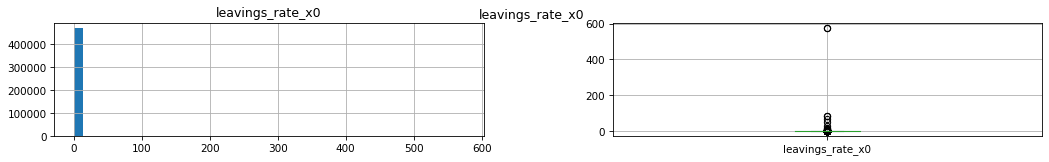

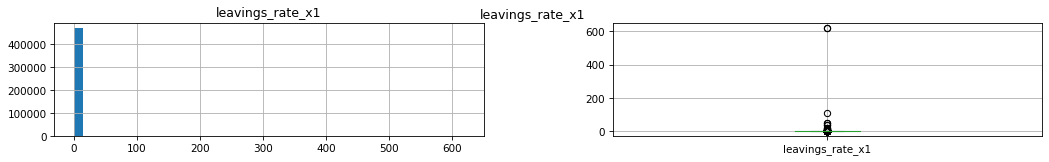

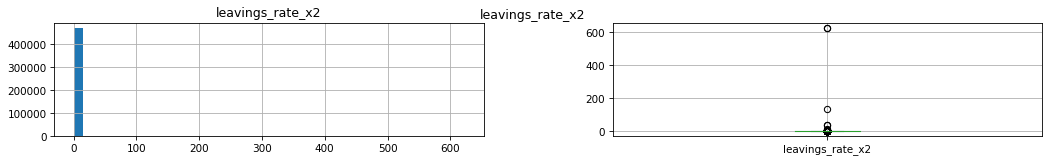

In [299]:
for col in [f'leavings_rate_x{i}' for i in range(3)]:  #reg_cols_min:
    draw_reg_col(df_filled, col)

In [321]:
leavings_rate_cols = [f'leavings_rate_x{i}' for i in range(9)]
df_leavers = df_filled[leavings_rate_cols]
df_leavers = (df_leavers.stack()[df_leavers.stack() > 150]).unstack()

In [322]:
df_leavers

,leavings_rate_x0,leavings_rate_x1,leavings_rate_x2,leavings_rate_x3,leavings_rate_x4
user_id,,,,,
96033bddbfc462fafd69d99d3423fae7a7553c73231d4a4586a8012b5010f245,574.0,619.0,622.0,617.0,493.0
e46df25f3288b84c9b8cb556d75820788ee94a402b5239333f7cad566e479a7e,573.5,619.0,621.5,617.5,493.5


Удалим этих двух игроков из тренировочной выборки

In [323]:
df_filled = df_filled.drop(df_leavers.index)

- - -
## Анализ данных<a class="anchor" id="preprocess"></a>

In [327]:
target_col = 'is_churned'

In [329]:
feature_cols = [col for col in df_filled.columns]
feature_cols.remove(target_col)
len(feature_cols)

127

### Анализ целевой переменной<a class="anchor" id="analysis_target"></a>

**Обзор распределения**

In [330]:
df_filled[target_col].value_counts()

0    455648
1    14029 
Name: is_churned, dtype: int64

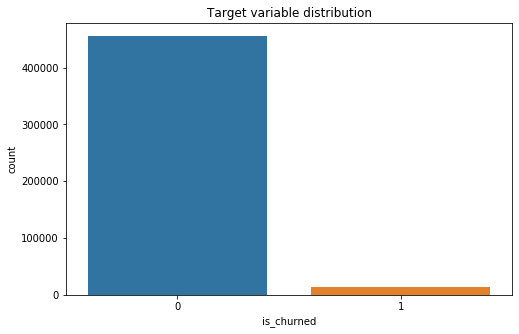

In [331]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target_col, data=df_filled)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

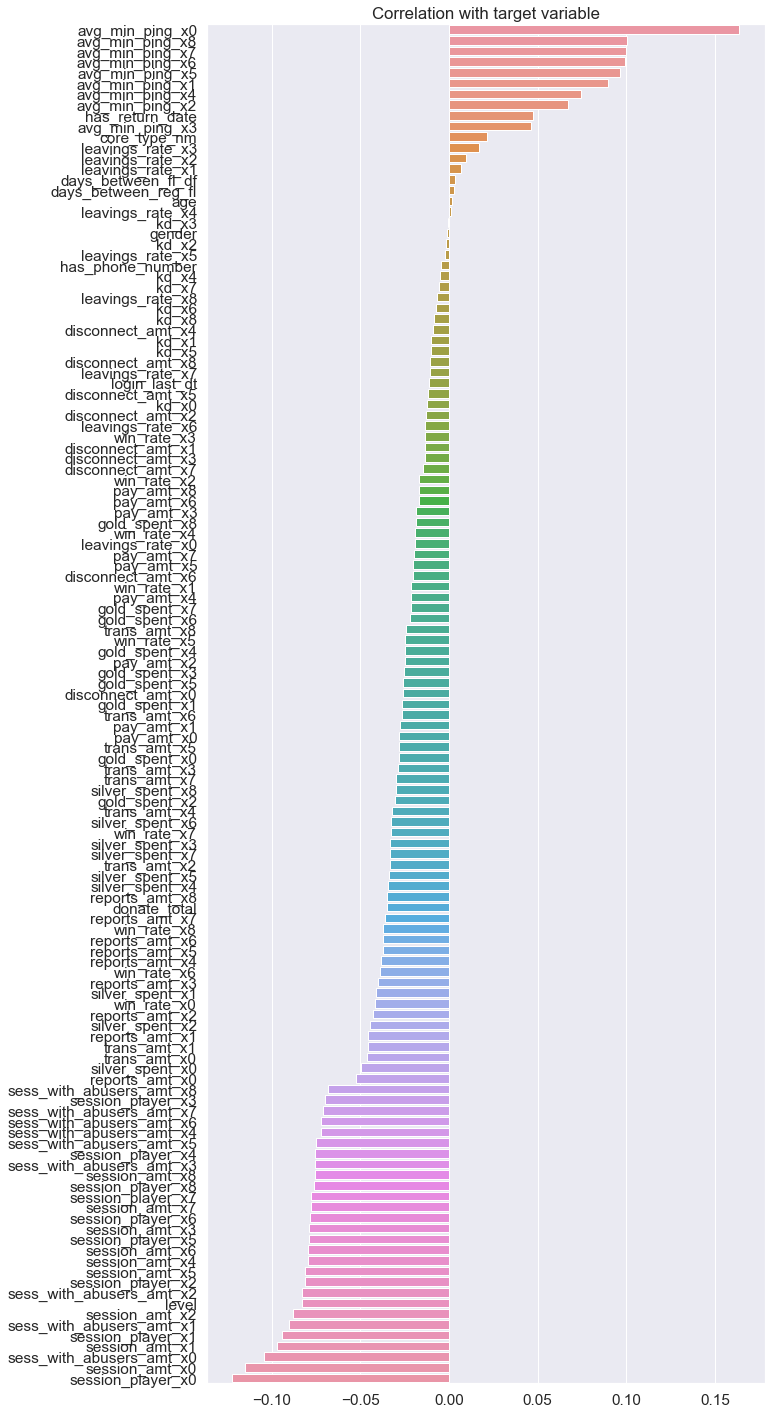

In [352]:
corr_with_target = df_filled[feature_cols + [target_col]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 25))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Видно, что средняя величина пинга — сильнее всего кореллирует с целевой переменной.

### Анализ признакового пространства<a class="anchor" id="analysis_corr"></a>

**Матрица корреляций**

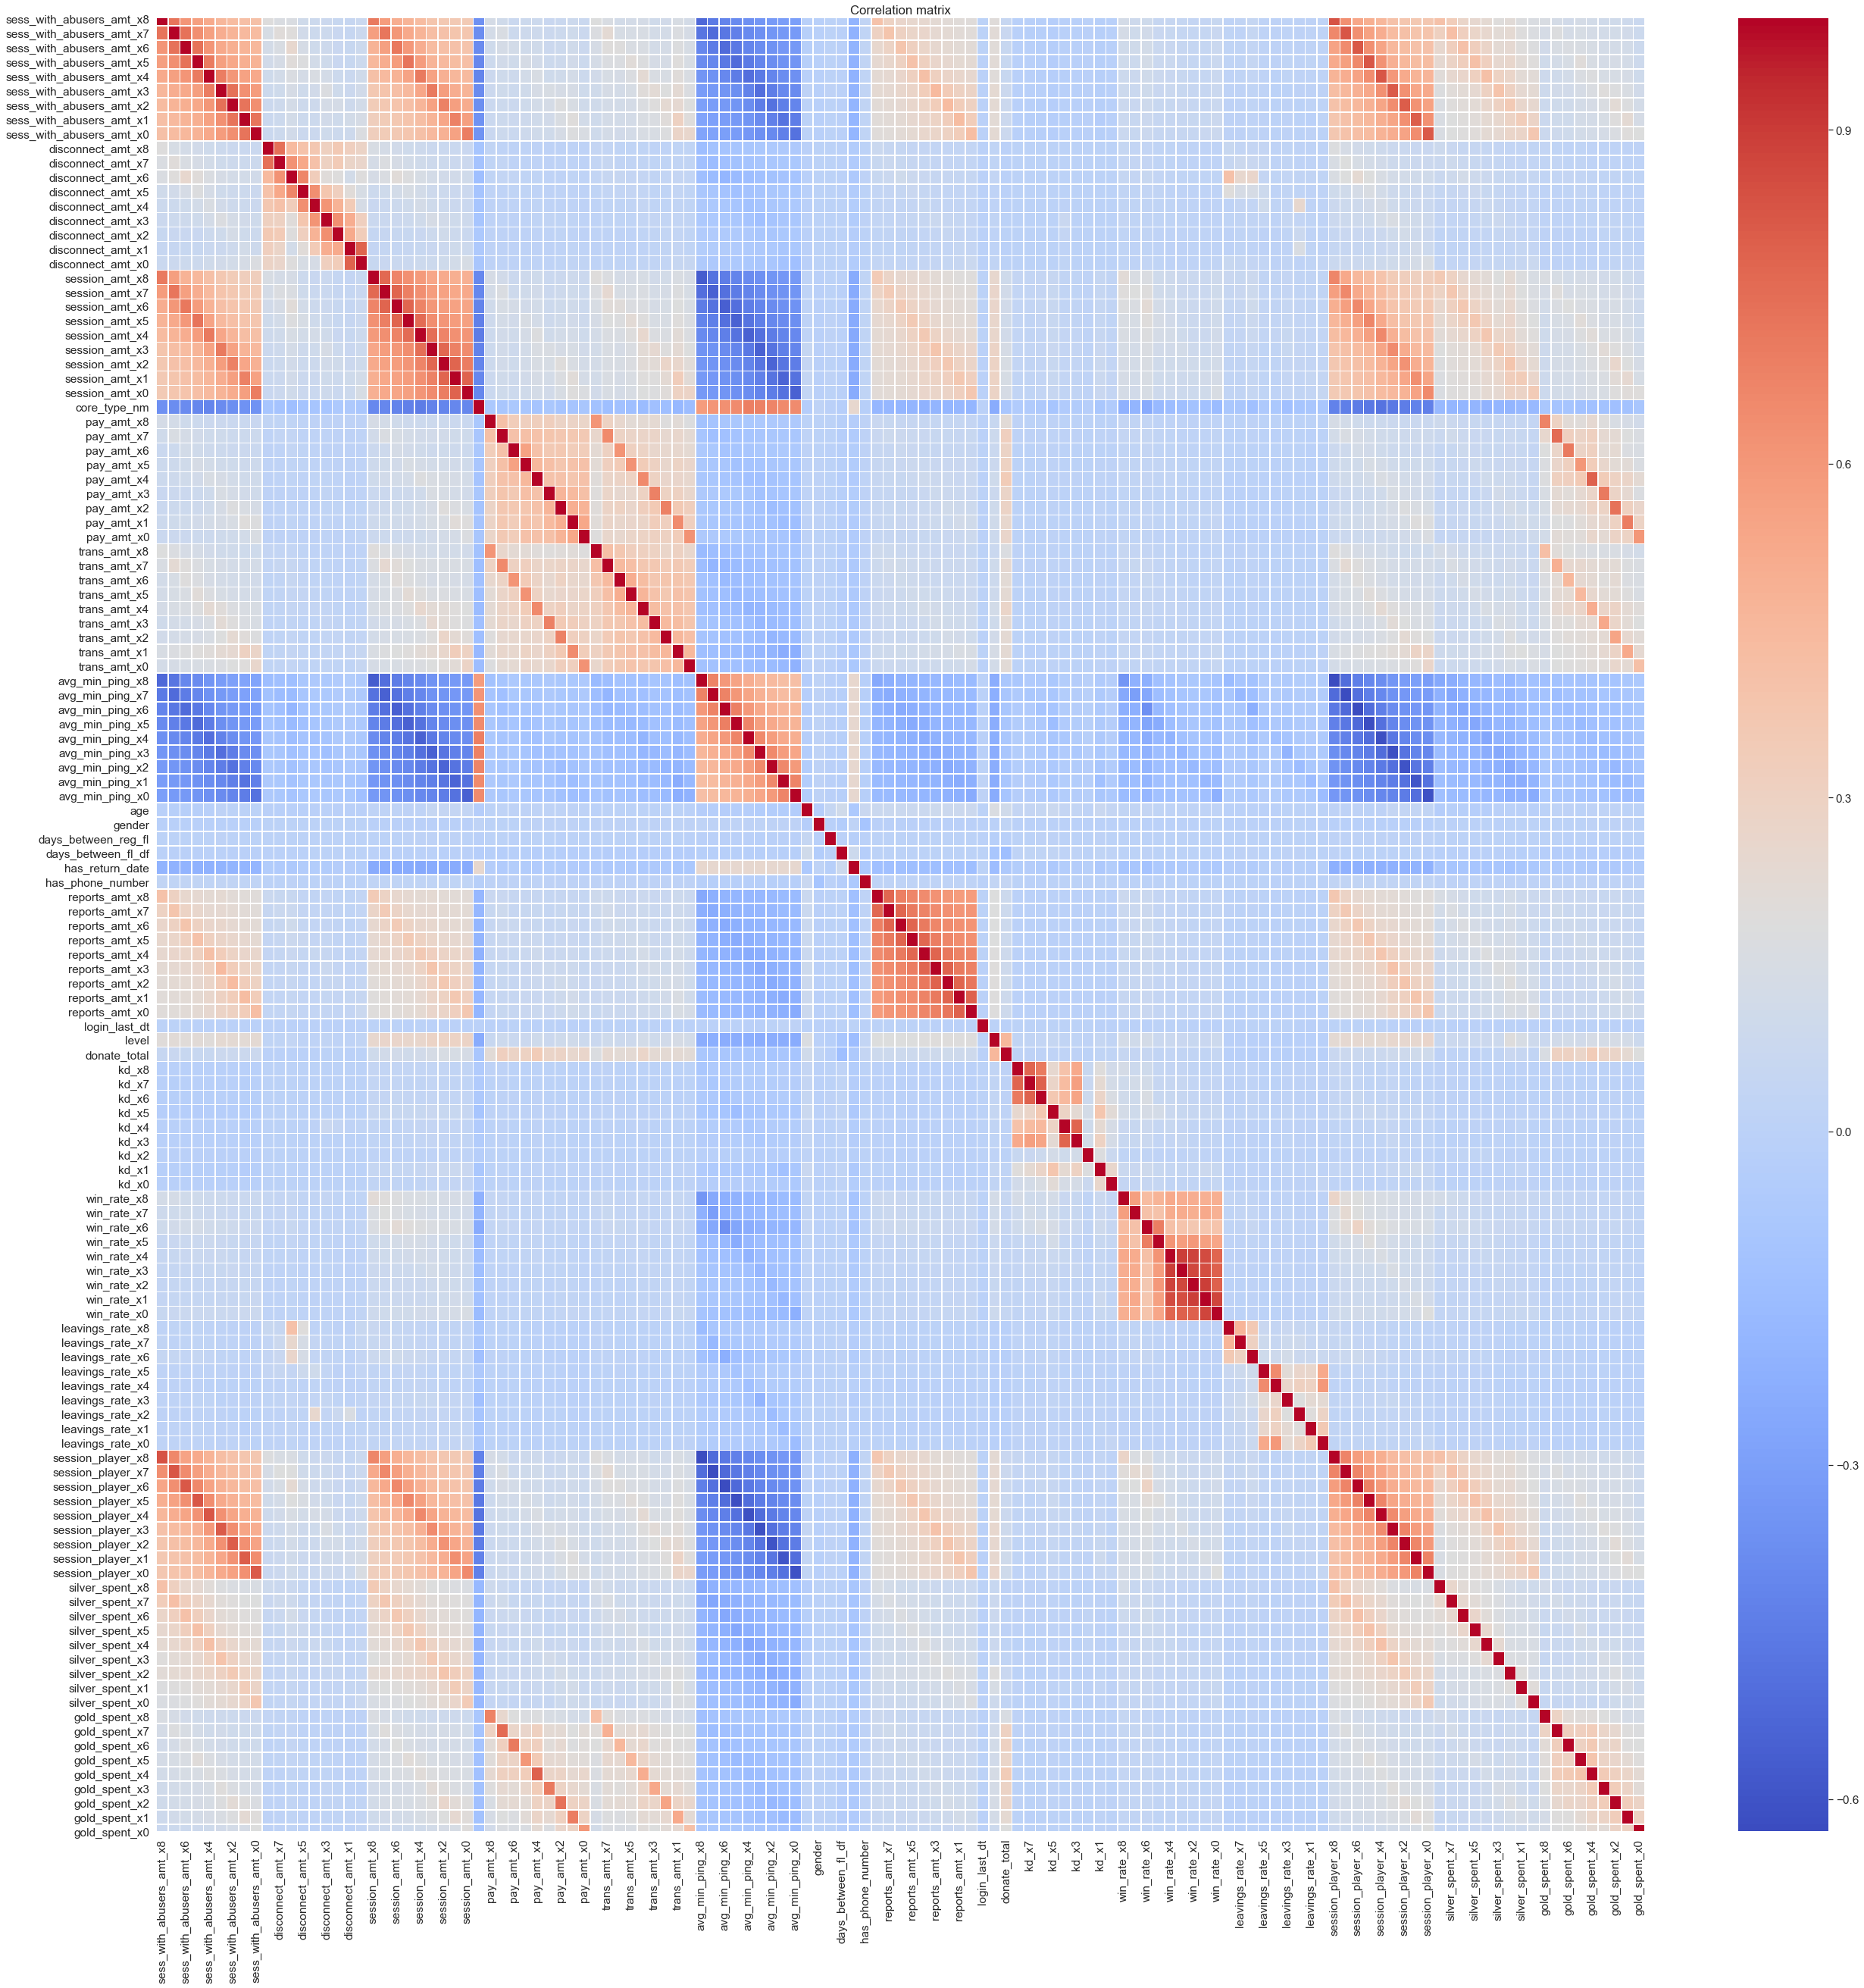

In [337]:
plt.figure(figsize=(44,44))

sns.set(font_scale=1.4)
sns.heatmap(df_filled[feature_cols].corr().round(3), annot=False, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Средняя величина пинга имеет отрицательную корреляцию практически со всеми другими признаками.

- - -
## Обучение на данных<a class="anchor" id="ml"></a>

### Нормализация<a class="anchor" id="ml_normalize"></a>

In [151]:
scaler = StandardScaler()
scaler.fit(df_train[feature_cols])
dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

In [153]:
%%write_and_run main.py
scaler = load('std_scaler.bin')

In [154]:
%%write_and_run main.py
@pipeline_step
def prep_scale(df):
    result = df.copy()
    result[feature_cols] = scaler.transform(df[feature_cols])
    return result

In [155]:
df_scaled = prep_scale(df_train)

### Балансировка классов<a class="anchor" id="ml_balancing"></a>

In [157]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [158]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_col)

df_balanced[target_col].value_counts()

0    341822
1    339372
Name: is_churned, dtype: int64

In [159]:
X_train = df_balanced.drop(columns=target_col)
y_train = df_balanced[target_col]

### Отбор признаков<a class="anchor" id="ml_feature_selection"></a>

### Разбиение на train и test<a class="anchor" id="ml_split"></a>

In [156]:
X = df_scaled[feature_cols]
y = df_scaled[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

### Подбор моделей<a class="anchor" id="ml_model_selection"></a>

In [160]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Логистическая регрессия**

In [161]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.50      0.56    341822
           1       0.59      0.72      0.65    339372

    accuracy                           0.61    681194
   macro avg       0.62      0.61      0.60    681194
weighted avg       0.62      0.61      0.60    681194

TEST

              precision    recall  f1-score   support

           0       0.98      0.50      0.66    113828
           1       0.04      0.72      0.08      3541

    accuracy                           0.51    117369
   macro avg       0.51      0.61      0.37    117369
weighted avg       0.95      0.51      0.64    117369

CONFUSION MATRIX

col_0           0      1
is_churned              
0           56822  57006
1             998   2543


**k-ближайших соседей**

In [162]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.92      0.95    341822
           1       0.93      0.99      0.96    339372

    accuracy                           0.96    681194
   macro avg       0.96      0.96      0.96    681194
weighted avg       0.96      0.96      0.96    681194

TEST

              precision    recall  f1-score   support

           0       0.97      0.90      0.93    113828
           1       0.04      0.14      0.06      3541

    accuracy                           0.87    117369
   macro avg       0.51      0.52      0.50    117369
weighted avg       0.94      0.87      0.91    117369

CONFUSION MATRIX

col_0            0      1
is_churned               
0           102093  11735
1             3044    497


**CatBoost**

In [163]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.58      0.64    341822
           1       0.65      0.77      0.70    339372

    accuracy                           0.68    681194
   macro avg       0.68      0.68      0.67    681194
weighted avg       0.68      0.68      0.67    681194

TEST

              precision    recall  f1-score   support

           0       0.98      0.57      0.72    113828
           1       0.04      0.60      0.08      3541

    accuracy                           0.58    117369
   macro avg       0.51      0.59      0.40    117369
weighted avg       0.95      0.58      0.70    117369

CONFUSION MATRIX

col_0           0      1
is_churned              
0           65429  48399
1            1402   2139


### Подбор гиперпараметров<a class="anchor" id="ml_hyper"></a>

In [164]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)

In [165]:
params = {'n_estimators':[100, 250, 500], 
          'max_depth':[5, 10, 15, 20],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [166]:
cv=KFold(n_splits=3, random_state=42, shuffle=True)

In [167]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

CPU times: user 13min 7s, sys: 5min 49s, total: 18min 56s
Wall time: 38min 33s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x1ad86ee410>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [100, 250, 500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [168]:
rs.best_params_

{'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.05}

In [169]:
rs.best_score_

0.6944673540580463

**Выбор наилучшей модели**

In [172]:
%%time

final_model = catb.CatBoostClassifier(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.05,
    silent=True, 
    random_state=42,
)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.58      0.64    341822
           1       0.64      0.77      0.70    339372

    accuracy                           0.67    681194
   macro avg       0.68      0.67      0.67    681194
weighted avg       0.68      0.67      0.67    681194

TEST

              precision    recall  f1-score   support

           0       0.98      0.57      0.72    113828
           1       0.04      0.62      0.08      3541

    accuracy                           0.57    117369
   macro avg       0.51      0.59      0.40    117369
weighted avg       0.95      0.57      0.70    117369

CONFUSION MATRIX

col_0           0      1
is_churned              
0           65243  48585
1            1360   2181
CPU times: user 12min 50s, sys: 6min 15s, total: 19min 6s
Wall time: 13min 33s


### Проверка качества, борьба с переобучением<a class="anchor" id="ml_overfittig"></a>

### Сохранение модели<a class="anchor" id="ml_persist"></a>

- - -
## Экспорт результатов<a class="anchor" id="export"></a>

- - -
## Интерпретация результатов<a class="anchor" id="interpretation"></a>